In [ ]:
import pandas as pd
import os

# Load the datasets
gdp_path = "raw_data/gdp_sheet.csv"
cpi_path = "raw_data/cpi_sheet.csv"
pat_path = "raw_data/company_pat.csv"


# Read CSVs
df_gdp = pd.read_csv(gdp_path, skiprows=1)  # Skip the merged header row
df_cpi = pd.read_csv(cpi_path)
df_pat = pd.read_csv(pat_path)

In [36]:


# --- SETUP FOR IDEMPOTENCY ---
output_folder = "cleaned_data"
output_filename = "gdp_data_cleaned.csv"  # Appending suffix _cleaned
output_path = os.path.join(output_folder, output_filename)

# Create the folder if it doesn't exist (Idempotent operation)
os.makedirs(output_folder, exist_ok=True)

# --- CLEANING GDP DATA ---
# The first column is unnamed, rename it to 'Sector'
df_gdp_cleaned = df_gdp.rename(columns={df_gdp.columns[0]: 'Sector'})

# Create a combined category from Sector and GDP SUB SECTOR for better clarity
df_gdp_cleaned['Category'] = df_gdp_cleaned['Sector'].fillna('') + ' - ' + df_gdp_cleaned['GDP SUB SECTOR'].fillna('')
df_gdp_cleaned['Category'] = df_gdp_cleaned['Category'].str.strip(' - ')  # Clean up formatting

# Identify year columns (2015-2024)
year_cols = [col for col in df_gdp_cleaned.columns if col.isdigit() and 2015 <= int(col) <= 2024]
year_cols = sorted(year_cols)

# Keep only Category and year columns
df_gdp_cleaned = df_gdp_cleaned[['Category'] + year_cols]

# Remove commas and convert to numeric
for col in year_cols:
    df_gdp_cleaned[col] = pd.to_numeric(df_gdp_cleaned[col].astype(str).str.replace(',', ''), errors='coerce')

# Calculate GDP YoY Growth (%)
df_growth = df_gdp_cleaned.copy()
for i in range(1, len(year_cols)):
    curr = year_cols[i]
    prev = year_cols[i-1]
    df_growth[curr] = ((df_gdp_cleaned[curr] - df_gdp_cleaned[prev]) / df_gdp_cleaned[prev]) * 100

# Calculate Contribution in 2024 (%)
total_gdp_2024 = df_gdp_cleaned[year_cols].iloc[:, -1].sum()  # Sum of all sectors
df_gdp_cleaned['Contribution_2024'] = (df_gdp_cleaned['2024'] / total_gdp_2024) * 100

# --- SAVE TO DISK ---
df_gdp_cleaned.to_csv(output_path, index=False)

print(f"GDP Data Cleaned Successfully and saved to: {output_path}")
print(f"Shape: {df_gdp_cleaned.shape}")
print(f"Years Available: {year_cols}")
print("\nFirst few rows:")
df_gdp_cleaned.head()

GDP Data Cleaned Successfully and saved to: cleaned_data\gdp_data_cleaned.csv
Shape: (19, 12)
Years Available: ['2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']

First few rows:


,Category,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,Contribution_2024
0,Agriculture - Agriculture,15952220.14,16607337.33,17179495.29,17544147.74,17958583.71,18348175.94,18738414.42,19091072.82,19306490.28,19535878.83,24.638704
1,Manufacturing - Oil & Gas,6732507.57,5759816.75,6031717.60,6092477.10,6362630.77,5819391.23,5366193.41,4391424.72,4266504.99,4473237.41,5.641659
2,Manufacturing,6586618.63,6302232.45,6288896.80,6420590.28,6469831.88,6291592.13,6502257.60,6661391.84,6754959.28,6848461.32,8.637298
3,Power,272431.53,231569.73,269620.92,289292.30,275231.59,267245.91,340923.42,333391.70,351936.63,353922.20,0.446368
4,"Water Supply, Waste Mgmt. & Remediation",94883.16,103675.42,107991.01,115780.10,122112.04,126769.71,150013.06,170449.89,192004.93,208142.37,0.262510


In [37]:

output_folder = "cleaned_data"
output_filename = "cpi_data_cleaned.csv"  # Appending suffix _cleaned
output_path = os.path.join(output_folder, output_filename)

# Create the folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# --- CLEANING CPI DATA ---

# 2. Rename the first column and trim whitespace from component names
df_cpi.rename(columns={df_cpi.columns[0]: 'Component'}, inplace=True)
df_cpi['Component'] = df_cpi['Component'].str.strip()

# 3. Clean numeric values (remove commas and convert to float)
year_cols = [c for c in df_cpi.columns if c != 'Component']
for col in year_cols:
    if df_cpi[col].dtype == 'object':
        df_cpi[col] = df_cpi[col].str.replace(',', '').astype(float)

# 4. Categorize data (Index values vs Summary Percentages)
percentage_rows = ['Month-on (%)', 'Year-on (%)', '12-month average (%)']
df_cpi['Metric_Type'] = df_cpi['Component'].apply(
    lambda x: 'Percentage' if x in percentage_rows else 'Index'
)

# 5. Restructure to LONG format (Tidy Data)
df_long = df_cpi.melt(
    id_vars=['Component', 'Metric_Type'], 
    value_vars=year_cols, 
    var_name='Date_Raw', 
    value_name='Value'
)

# 6. Parse Year as an integer
df_long['Year'] = df_long['Date_Raw'].str.extract(r'(\d{4})').astype(int)

# 7. Final selection and sorting
df_cpi_cleaned = df_long[['Year', 'Component', 'Value', 'Metric_Type']].sort_values(['Component', 'Year'])

# --- SAVE TO DISK ---
df_cpi_cleaned.to_csv(output_path, index=False)

print(f"CPI Data restructured to Tidy Format and saved to: {output_path}")
print(f"Shape: {df_cpi_cleaned.shape}")
df_cpi_cleaned.head()

CPI Data restructured to Tidy Format and saved to: cleaned_data\cpi_data_cleaned.csv
Shape: (200, 4)


,Year,Component,Value,Metric_Type
199,2015,12-month average (%),9.01,Percentage
179,2016,12-month average (%),15.70,Percentage
159,2017,12-month average (%),16.50,Percentage
139,2018,12-month average (%),12.10,Percentage
119,2019,12-month average (%),11.40,Percentage


In [38]:


# --- SETUP FOR IDEMPOTENCY ---
output_folder = "cleaned_data"
output_filename = "pat_data_cleaned.csv"  # Appending suffix _cleaned
output_path = os.path.join(output_folder, output_filename)

# Create the folder if it doesn't exist (Idempotent operation)
os.makedirs(output_folder, exist_ok=True)

# --- CLEANING PAT DATA ---
# Rename first column to 'Company'
df_pat.rename(columns={df_pat.columns[0]: 'Company'}, inplace=True)

# Trim whitespace from company names
df_pat['Company'] = df_pat['Company'].str.strip()

# Define year columns (2015-2024)
pat_years = sorted([str(y) for y in range(2015, 2025)])

# Keep only Company and year columns
df_pat = df_pat[['Company'] + pat_years]

# Remove empty rows (where Company is NaN or empty)
df_pat = df_pat[df_pat['Company'].notna()].reset_index(drop=True)
df_pat = df_pat[df_pat['Company'].str.strip() != ''].reset_index(drop=True)

# Clean numeric data (remove commas and convert to numeric)
for col in pat_years:
    df_pat[col] = pd.to_numeric(df_pat[col].astype(str).str.replace(',', ''), errors='coerce')

# Restructure to LONG format (Tidy Data)
df_pat_long = df_pat.melt(
    id_vars=['Company'],
    value_vars=pat_years,
    var_name='Year',
    value_name='PAT_Millions'
)

# Convert Year to integer
df_pat_long['Year'] = df_pat_long['Year'].astype(int)

# Sort by Company and Year
df_pat_long = df_pat_long.sort_values(['Company', 'Year']).reset_index(drop=True)

# Calculate PAT Growth (%)
df_pat_long['PAT_Growth_%'] = df_pat_long.groupby('Company')['PAT_Millions'].pct_change() * 100

# Calculate 2024 contribution (% of total profits, excluding negative values)
total_pat_2024 = df_pat[df_pat['2024'] > 0]['2024'].sum()
# Create a mapping dictionary for contribution
contribution_map = df_pat[df_pat['2024'] > 0].set_index('Company')['2024'] / total_pat_2024 * 100
df_pat['Contribution_2024'] = df_pat['Company'].map(contribution_map)

# Add contribution to long format
df_pat_long = df_pat_long.merge(df_pat[['Company', 'Contribution_2024']], on='Company', how='left')

# --- SAVE TO DISK ---
df_pat_long.to_csv(output_path, index=False)

print(f"PAT Data Cleaned Successfully and saved to: {output_path}")
print(f"Shape: {df_pat_long.shape}")
print(f"Years Available: {pat_years}")
print("\nFirst few rows:")
df_pat_long.head(10)
print("\nData Summary:")
df_pat_long.groupby('Company')['PAT_Millions'].agg(['min', 'max', 'mean'])

PAT Data Cleaned Successfully and saved to: cleaned_data\pat_data_cleaned.csv
Shape: (70, 5)
Years Available: ['2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']

First few rows:

Data Summary:


,min,max,mean
Company,,,
Conoil,1440,9868,3750.5
Dangote Cement,142858,503247,307287.2
Information & Communication – MTN,-400435,348727,76819.1
Nestle Niger,-164595,48965,-11570.0
Okomu Oil,2726,39958,12170.5
Seplat Energy,-85322,144792,27662.7
Zenith Bank,105663,936158,300331.0


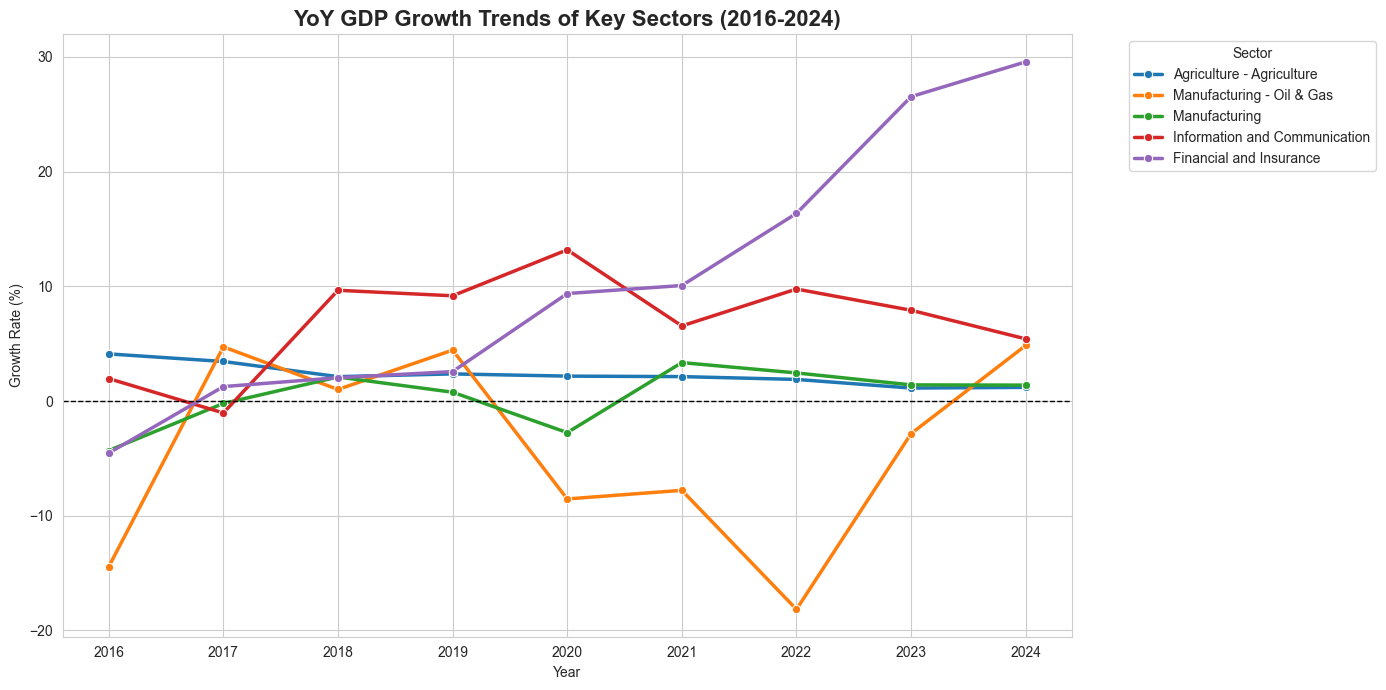

C:\Users\PC\AppData\Local\Temp\ipykernel_10388\1765503222.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_5_growth, x='2024', y='Category', palette='viridis')


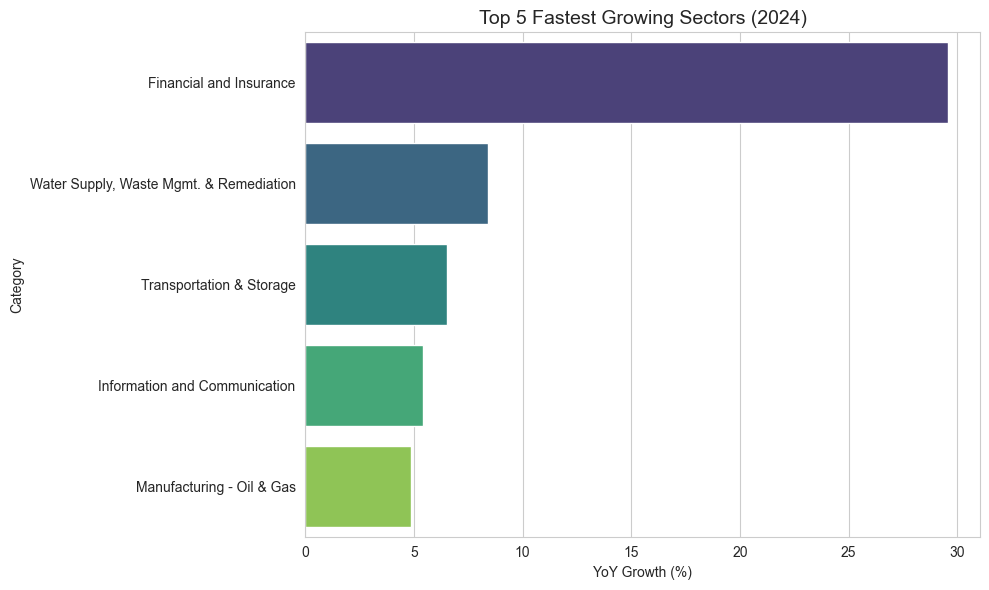

C:\Users\PC\AppData\Local\Temp\ipykernel_10388\1765503222.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_inflation_2024.values, y=top_inflation_2024.index, palette='magma')


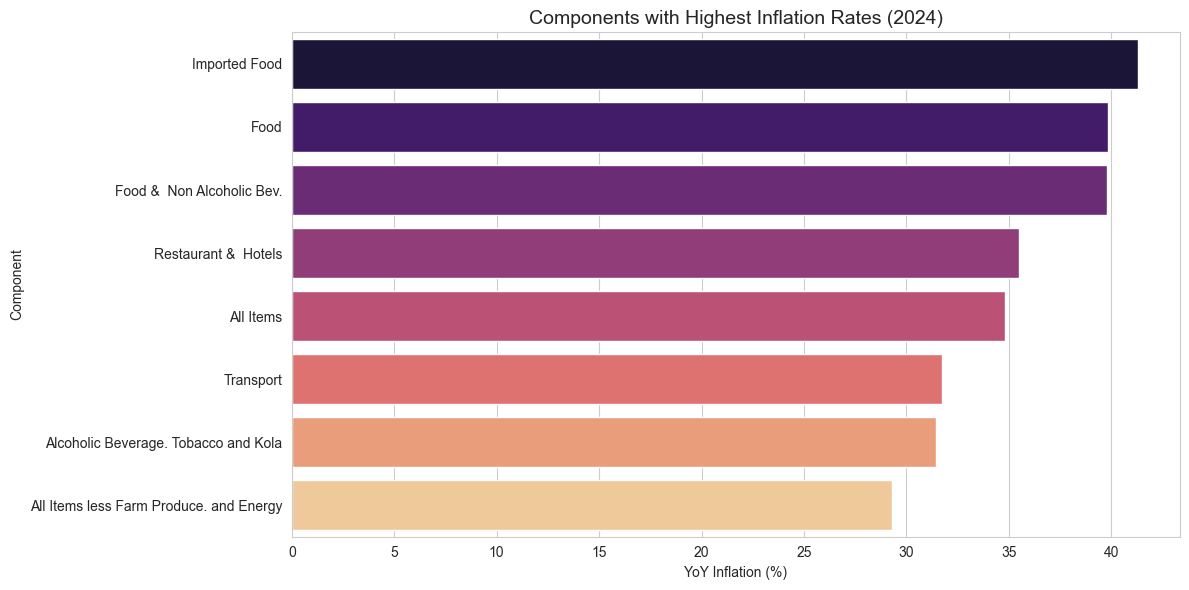

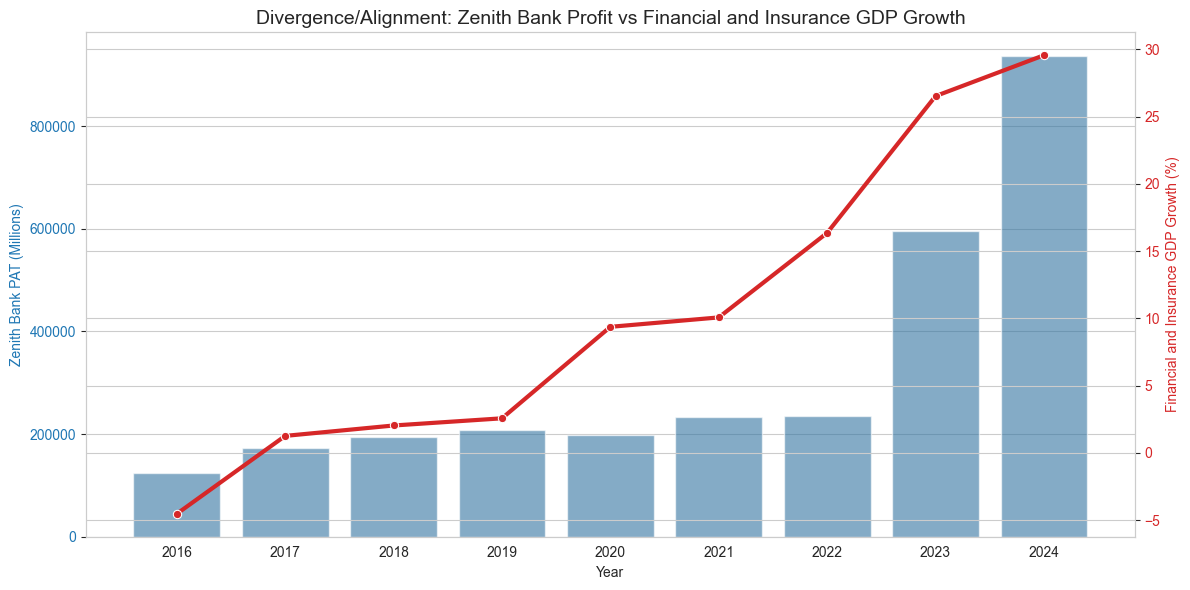

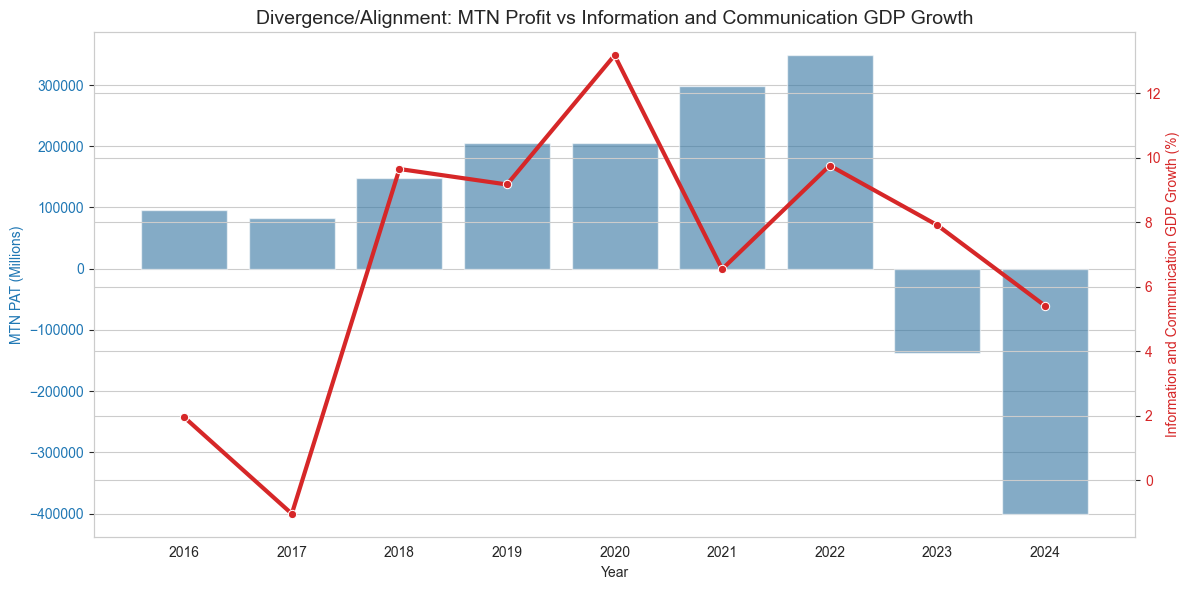

Analysis Complete. Charts generated.


In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set Plot Style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# --- LOAD DATA ---
df_gdp = pd.read_csv("cleaned_data/gdp_data_cleaned.csv")
df_cpi = pd.read_csv("cleaned_data/cpi_data_cleaned.csv")
df_pat = pd.read_csv("cleaned_data/pat_data_cleaned.csv")

# ==========================================
# PART 1: GDP ANALYSIS
# ==========================================

# 1. Transform GDP to Long Format for easy plotting
gdp_years = [str(y) for y in range(2015, 2025)]
df_gdp_long = df_gdp.melt(id_vars=['Category'], value_vars=gdp_years, var_name='Year', value_name='GDP')
df_gdp_long['Year'] = df_gdp_long['Year'].astype(int)

# 2. Calculate YoY Growth for Plotting
df_gdp_growth = df_gdp.set_index('Category')[gdp_years].pct_change(axis=1) * 100
df_gdp_growth = df_gdp_growth.reset_index()
df_gdp_growth_long = df_gdp_growth.melt(id_vars=['Category'], value_vars=gdp_years[1:], var_name='Year', value_name='Growth_Rate')

# 3. Top 5 Sectors 2024
top_5_growth = df_gdp_growth[['Category', '2024']].sort_values(by='2024', ascending=False).head(5)

# --- PLOT 1: GDP Sector Growth Trends (Selected Key Sectors) ---
selected_sectors = ['Financial and Insurance', 'Manufacturing', 'Information and Communication', 'Agriculture - Agriculture', 'Manufacturing - Oil & Gas']
subset_growth = df_gdp_growth_long[df_gdp_growth_long['Category'].isin(selected_sectors)]

plt.figure(figsize=(14, 7))
sns.lineplot(data=subset_growth, x='Year', y='Growth_Rate', hue='Category', marker='o', linewidth=2.5)
plt.title('YoY GDP Growth Trends of Key Sectors (2016-2024)', fontsize=16, fontweight='bold')
plt.ylabel('Growth Rate (%)')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('gdp_growth_trends.png')
plt.show()

# --- PLOT 2: Top 5 Growth Sectors 2024 ---
plt.figure(figsize=(10, 6))
sns.barplot(data=top_5_growth, x='2024', y='Category', palette='viridis')
plt.title('Top 5 Fastest Growing Sectors (2024)', fontsize=14)
plt.xlabel('YoY Growth (%)')
plt.tight_layout()
plt.savefig('top_5_sectors_2024.png')
plt.show()

# ==========================================
# PART 2: CPI ANALYSIS
# ==========================================

# 1. Calculate YoY Inflation for Components (using Index)
df_cpi_indices = df_cpi[df_cpi['Metric_Type'] == 'Index'].copy()
df_cpi_wide = df_cpi_indices.pivot(index='Component', columns='Year', values='Value')
df_cpi_inflation = df_cpi_wide.pct_change(axis=1) * 100
top_inflation_2024 = df_cpi_inflation[2024].sort_values(ascending=False).head(8)

# --- PLOT 3: Inflation Heatmap (2024) ---
plt.figure(figsize=(12, 6))
sns.barplot(x=top_inflation_2024.values, y=top_inflation_2024.index, palette='magma')
plt.title('Components with Highest Inflation Rates (2024)', fontsize=14)
plt.xlabel('YoY Inflation (%)')
plt.tight_layout()
plt.savefig('cpi_inflation_2024.png')
plt.show()

# ==========================================
# PART 3: COMPANY vs SECTOR
# ==========================================

# Filter for Zenith Bank (Success Story) and MTN (Struggling Story)
company_sector_map = {
    'Zenith Bank': 'Financial and Insurance',
    'MTN': 'Information and Communication'
}

for company, sector in company_sector_map.items():
    # Get Company Data
    comp_data = df_pat[df_pat['Company'] == company]
    
    # Get Sector Data
    sect_data = df_gdp_growth_long[df_gdp_growth_long['Category'] == sector].copy()
    sect_data['Year'] = sect_data['Year'].astype(int)
    
    # Merge
    merged = pd.merge(comp_data[['Year', 'PAT_Millions']], sect_data[['Year', 'Growth_Rate']], on='Year')
    
    # Plot Dual Axis
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Bar for Company PAT
    color = 'tab:blue'
    ax1.set_xlabel('Year')
    ax1.set_ylabel(f'{company} PAT (Millions)', color=color)
    sns.barplot(data=merged, x='Year', y='PAT_Millions', ax=ax1, color=color, alpha=0.6)
    ax1.tick_params(axis='y', labelcolor=color)
    
    # Line for Sector GDP
    ax2 = ax1.twinx() 
    color = 'tab:red'
    ax2.set_ylabel(f'{sector} GDP Growth (%)', color=color)
    sns.lineplot(data=merged, x=merged.index, y='Growth_Rate', ax=ax2, color=color, marker='o', linewidth=3)
    ax2.tick_params(axis='y', labelcolor=color)
    
    plt.title(f'Divergence/Alignment: {company} Profit vs {sector} GDP Growth', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'{company}_vs_Sector.png')
    plt.show()

print("Analysis Complete. Charts generated.")